In [ ]:
# TIDAK PERLU DIJALANKAN
# !wget https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip
# !wget https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Metadata.csv
# !wget https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv
# !wget https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Test_Input.zip
# !unzip drive/My\ Drive/FP_ISIC_Melanoma_Dataset/ISIC_2019_Test_Input.zip -d drive/My\ Drive/FP_ISIC_Melanoma_Dataset

In [ ]:
# Indra
# !unzip ISIC_2019_Test_Input.zip -d FP_ISIC_Melanoma_Dataset
# !pip3 install pydicom

In [20]:
import pandas as pd
import os
from shutil import copyfile
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import getcwd
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# Explore Data
data_labeled_dir = "./labeled_images/"
totalImage = len(os.listdir(data_labeled_dir+"MEL"))+len(os.listdir(data_labeled_dir+"BCC"))+len(os.listdir(data_labeled_dir+"NV"))+len(os.listdir(data_labeled_dir+"AK"))+len(os.listdir(data_labeled_dir+"VASC"))+len(os.listdir(data_labeled_dir+"BKL"))+len(os.listdir(data_labeled_dir+"SCC"))
print("Total Image for BCC: "+str(len(os.listdir(data_labeled_dir+"BCC"))))
print("Total Image for NV: "+str((len(os.listdir(data_labeled_dir+"NV")))))
print("Total Image for AK: "+str((len(os.listdir(data_labeled_dir+"AK")))))
print("Total Image for VASC: "+str((len(os.listdir(data_labeled_dir+"VASC")))))
print("Total Image for BKL: "+str((len(os.listdir(data_labeled_dir+"BKL")))))
print("Total Image for SCC: "+str((len(os.listdir(data_labeled_dir+"SCC")))))
print("Total Image for DF: "+str((len(os.listdir(data_labeled_dir+"DF")))))
print("Total Image for MEL: "+str((len(os.listdir(data_labeled_dir+"MEL")))))

# Total Image
print("Total Image: "+str(totalImage))

Total Image for BCC: 1361
Total Image for NV: 9943
Total Image for AK: 351
Total Image for VASC: 173
Total Image for BKL: 1817
Total Image for SCC: 337
Total Image for DF: 155
Total Image for MEL: 2574
Total Image: 16556


In [4]:
# Explore Data
import matplotlib.pyplot as plt
import cv2

data_labeled_dir

'./labeled_images/'

In [5]:
lesion_type_dict = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis-like lesions ',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC':'Squamous Cell Carcinoma'
}

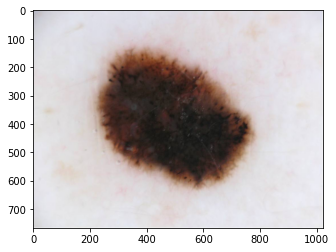

In [6]:
import matplotlib.image as mpimg
single_image = os.listdir(data_labeled_dir+'MEL')
image_path =  data_labeled_dir+'MEL/'+single_image[2]
img=mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()

In [7]:
os.listdir("labeled_images/")

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'skin_normal.jpg', 'VASC']

In [8]:
img = cv2.imread(image_path,0)

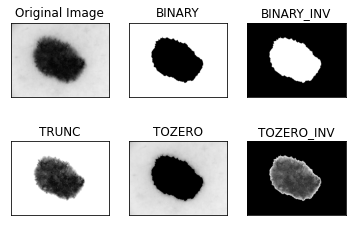

In [9]:
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

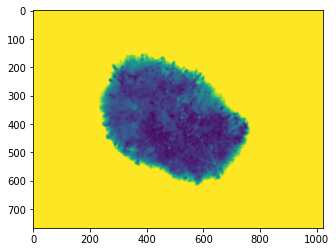

In [10]:
plt.imshow(images[3])
plt.show()

In [11]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [12]:
# Define a Callback class that stops training once accuracy reaches 97.0%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.97):
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True

In [13]:
# Model Hyperparameter
train_data_dir = data_labeled_dir
BATCH_SIZE= 2
WIDTH_SIZE = 150
HEIGHT_SIZE = 150

In [14]:
# WIRA

# Training_Input = training (80%), testing(20%) #fokus

# INDRA
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(WIDTH_SIZE, HEIGHT_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training') # set as training data


# WIRA
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(WIDTH_SIZE, HEIGHT_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 15043 images belonging to 8 classes.
Found 1668 images belonging to 8 classes.


In [21]:
# Define the model
callbacks = myCallback()

# WIRA
# Use no more than 2 Conv2D and 2 MaxPooling2D
model = tf.keras.models.Sequential([
    # Your Code Here
    # This is the first convolution
    tf.keras.layers.Conv2D(32,(3,3), activation='relu',padding='same', input_shape=(WIDTH_SIZE, HEIGHT_SIZE,3)),
    tf.keras.layers.Conv2D(32,(3,3), activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')]
    )

# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile Model. 
model.compile(loss = 'categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [23]:
# INDRA
# history = model.fit(train_generator,validation_data = validation_generator,epochs = 25)

In [25]:
# import matplotlib.pyplot as plt
# plt.plot(history.history["accuracy"])
# plt.title("Accuracy")
# plt.ylabel('accuracy')
# plt.xlabel('epochs')

In [46]:
# model = tf.keras.models.Sequential()
model.save("model_fp_59.h5")

In [29]:
from tensorflow.keras.models import load_model
 
# load model
model = load_model('model_fp_59.h5')
# summarize model.
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 146, 146, 64)      1792      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 33, 33, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 16384)            

In [37]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
 
data_testing_path_image = data_labeled_dir+"AK/"+os.listdir(data_labeled_dir+"AK/")[0]
    
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(148, 148))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 148, 148, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

image = load_image(data_testing_path_image)

In [38]:
model.predict(image)

array([[2.5899939e-02, 1.0331087e-03, 1.4583297e-03, 3.4612876e-01,
        4.7132221e-01, 3.3484917e-02, 1.2053358e-01, 1.3905158e-04]],
      dtype=float32)

In [39]:
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [40]:
tflitemodel = converter.convert()

In [41]:
with open("model_fp_59.tflite","wb") as f:
    f.write(tflitemodel)